## Analyse the raw features and extract the clipping parameters 

Look at the raw vertices values for each feature 

Use of a sigma clipping (value at 5std from the mean) to be used to filter extreme vertices for individual 
subject

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from aidhs.paths import BASE_PATH

Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript


In [2]:
features_title = {
                'label-dentate.curvature' : 'curvature dentate',
                'label-dentate.gyrification' : 'gyrification dentate',
                'label-hipp.curvature' : 'curvature hippo',
                'label-hipp.gauss-curv_filtered': 'intrinsic curvature hippo',
                'label-hipp.gyrification' : 'gyrification hippo',
                'label-hipp.mean-curv' : 'mean curvature hippo',
                'label-hipp.thickness' : 'thickness hippo',
}

def return_features_title(feature):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]

### Distribution raw features

In [3]:
hemis=['lh', 'rh']

#create cohort
cohort= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_rawT1.hdf5', dataset='dataset_C-P-DC_alltrain.csv')

#get feature list
features = cohort.full_feature_list

#get subjects 
subjects = cohort.get_subject_ids(lesional_only = False)
len(subjects)


363

In [4]:
features = [
 '.label-dentate.curvature',
 '.label-dentate.gyrification',
 '.label-hipp.curvature',
 '.label-hipp.gauss-curv_filtered_sm1',
 '.label-hipp.gyrification',
 '.label-hipp.thickness'
 ]



In [5]:
#get distributions of raw feature
sub_features=sorted(features)

vals_feats={}
for i,feature in enumerate(sub_features):
    vals_feats[feature]=[]
    if 'label-dentate' in feature:
        mask = cohort.dentate_mask 
    else:
        mask = cohort.hippo_mask
    for subject in subjects:
        subj = AidhsSubject(subject, cohort=cohort)
        vals_lh= subj.load_feature_values(feature, 'lh')
        vals_rh= subj.load_feature_values(feature, 'rh')
        vals=np.array(np.array(np.hstack([vals_lh[mask], vals_rh[mask]])))
        if vals.sum()!=0:
            vals_feats[feature].append(vals)
        else:
            print(f'feature {feature} does not exist for {subject}')
len(vals_feats)       


6

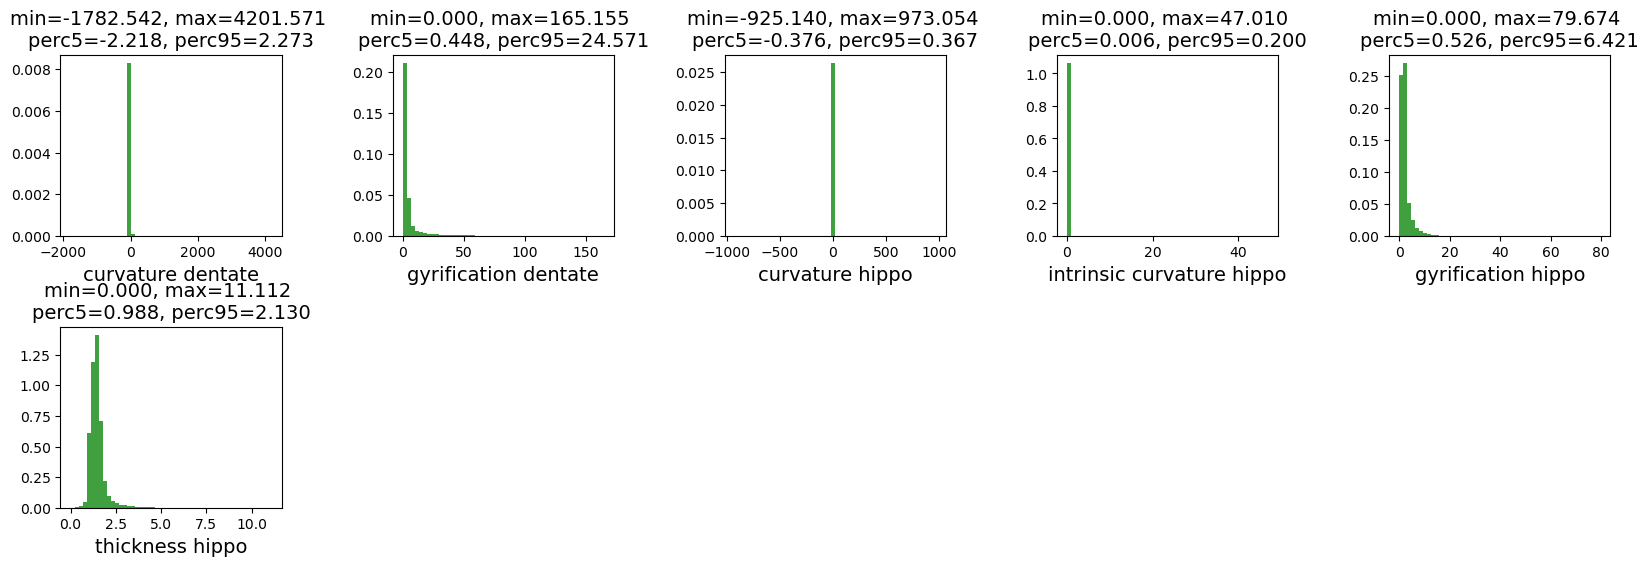

In [6]:
# plot distributions

fig = plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(6, 5, hspace=0.5, wspace=0.5)
axs = []

features_clipping_percentiles = {}
features_clipping_sigma = {}
for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))
    data = np.array(vals_feats[feature]).flatten()
    axs[i].hist(data, 50, density=True, facecolor='g', alpha=0.75)
    axs[i].set_xlabel(return_features_title(feature), fontsize=14)

    # sigma clip
    factor=5
    quartiles = np.percentile(data, [25, 50, 75])
    mu, sig = quartiles[1], 0.74 * (quartiles[2] - quartiles[0])
    features_clipping_sigma[feature]=[mu-factor*sig, mu+factor*sig]

    # percentile clip
    features_clipping_percentiles[feature]= [np.percentile(data,5),np.percentile(data,95)]

    #plot
    axs[i].set_title('min={:.3f}, max={:.3f} \nperc5={:.3f}, perc95={:.3f}'.format(min(data), max(data), 
                                                                        np.percentile(data,5), np.percentile(data,95)), fontsize=14)

    

In [7]:
features_clipping_sigma

{'.label-dentate.curvature': [-2.1463347196578977, 2.1662665277719495],
 '.label-dentate.gyrification': [-8.379041808843612, 12.426038879156112],
 '.label-hipp.curvature': [-0.9856418583542108, 0.9846630234271287],
 '.label-hipp.gauss-curv_filtered_sm1': [-0.09312128056772054,
  0.13306658123619855],
 '.label-hipp.gyrification': [-3.1803498625755307, 6.859679615497589],
 '.label-hipp.thickness': [0.022090148925781206, 2.759787607192993]}

In [8]:
import json
file = os.path.join(BASE_PATH, 'clipping_parameters_sigma.json' )
with open(file, "w") as outfile:
    json.dump(features_clipping_sigma, outfile)

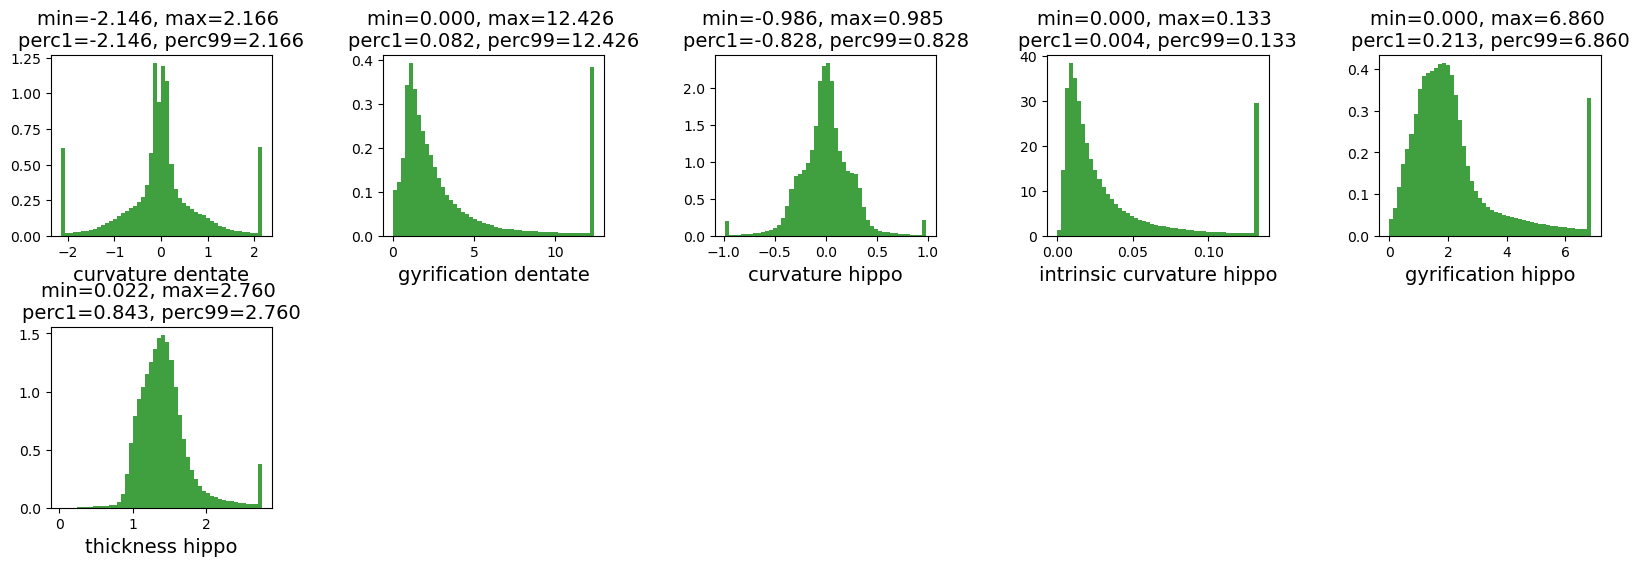

In [9]:
# plot distributions after clipping with sigma

fig = plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(6, 5, hspace=0.5, wspace=0.5)
axs = []

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))
    data = np.array(vals_feats[feature]).flatten()

    # CLIPPING
    data=np.clip(data, features_clipping_sigma[feature][0], features_clipping_sigma[feature][1] )

    axs[i].hist(data, 50, density=True, facecolor='g', alpha=0.75)
    axs[i].set_xlabel(return_features_title(feature), fontsize=14)
    axs[i].set_title('min={:.3f}, max={:.3f} \nperc1={:.3f}, perc99={:.3f}'.format(min(data), max(data), np.percentile(data,1), np.percentile(data,99)), fontsize=14)

    

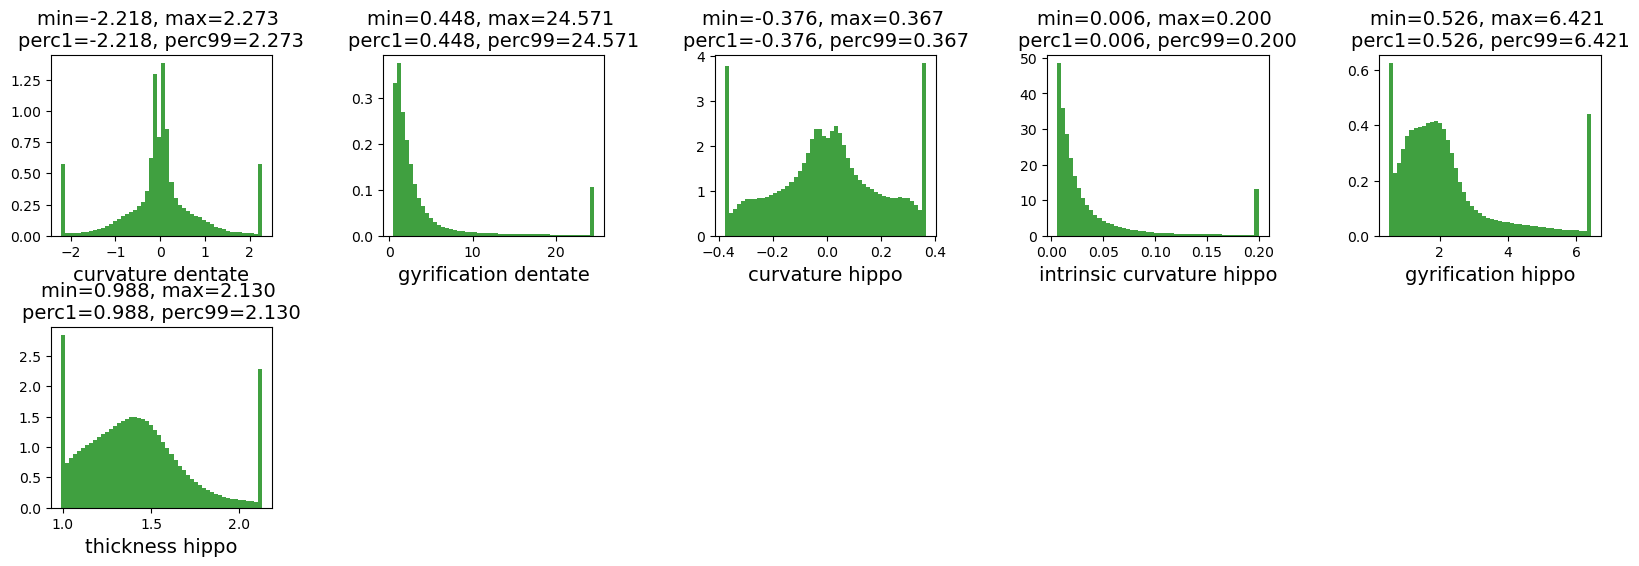

In [10]:
# plot distributions after clipping with percentile

fig = plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(6, 5, hspace=0.5, wspace=0.5)
axs = []

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))
    data = np.array(vals_feats[feature]).flatten()

    # CLIPPING
    data=np.clip(data, features_clipping_percentiles[feature][0], features_clipping_percentiles[feature][1] )

    axs[i].hist(data, 50, density=True, facecolor='g', alpha=0.75)
    axs[i].set_xlabel(return_features_title(feature), fontsize=14)
    axs[i].set_title('min={:.3f}, max={:.3f} \nperc1={:.3f}, perc99={:.3f}'.format(min(data), max(data), np.percentile(data,1), np.percentile(data,99)), fontsize=14)
